In [1]:
# Cell 1: Install all required packages

!pip install faster-whisper --quiet
!pip install fastapi uvicorn python-multipart nest-asyncio pyngrok --quiet
!apt-get install -y ffmpeg --quiet

print("✅ All packages installed!")
print("⚠️  Now go to Runtime → Restart Session, then run Cell 2 onwards!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 36.4 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
✅ All packages installed!
⚠️  Now go to Runtime → Restart Session, then run Cell 2 onwards!


In [1]:
# Cell 2: Import all libraries

import os
import subprocess
import torch
import nest_asyncio
import uvicorn
from faster_whisper import WhisperModel
from fastapi import FastAPI, File, UploadFile, Form
from fastapi.responses import JSONResponse
from pyngrok import ngrok
import threading
import time

nest_asyncio.apply()

device = "cuda" if torch.cuda.is_available() else "cpu"
compute_type = "float16" if device == "cuda" else "int8"

print(f"✅ Libraries imported!")
print(f"🖥️  Device: {device.upper()} | Compute type: {compute_type}")

✅ Libraries imported!
🖥️  Device: CUDA | Compute type: float16


In [2]:
# Cell 3: Load Faster Whisper model (run only once per session)
#
# Model options:
#   "tiny", "base", "small"   → Faster, less accurate
#   "medium", "large-v2"      → More accurate, slower
#   "large-v3"                → Best accuracy (recommended with GPU)
#
# Faster Whisper advantages over standard Whisper:
#   ✅ 4x faster inference
#   ✅ Less GPU memory usage
#   ✅ Same accuracy as original Whisper
#   ✅ Word-level timestamps built in

MODEL_SIZE = "base"  # Change to "small", "medium", "large-v2" if needed

print(f"⏳ Loading Faster Whisper model: '{MODEL_SIZE}' on {device.upper()}...")

model = WhisperModel(MODEL_SIZE, device=device, compute_type=compute_type)

print(f"✅ Faster Whisper model '{MODEL_SIZE}' loaded and ready!")

⏳ Loading Faster Whisper model: 'base' on CUDA...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Faster Whisper model 'base' loaded and ready!


In [3]:
# Cell 4: Define FastAPI app with /transcribe endpoint
#
# Faster Whisper returns segments as a generator.
# We iterate through them and format into Person 4's expected structure.
# Word-level timestamps are available directly — no separate alignment step needed.

app = FastAPI(title="Faster Whisper Transcription Service")

@app.get("/")
def root():
    return {
        "status": "Faster Whisper service is running!",
        "model": MODEL_SIZE,
        "device": device
    }

@app.post("/transcribe")
async def transcribe_video(
    video: UploadFile = File(...),
    job_id: str = Form(...)
):
    video_path = f"/tmp/{job_id}_video.mp4"
    audio_path = f"/tmp/{job_id}_audio.wav"

    try:
        print(f"\n📥 Received job_id: {job_id} | File: {video.filename}")

        # Step 1: Save uploaded video
        with open(video_path, "wb") as f:
            content = await video.read()
            f.write(content)
        print(f"✅ Video saved: {video_path}")

        # Step 2: Extract audio via ffmpeg (mono, 16kHz WAV)
        ffmpeg_cmd = [
            "ffmpeg", "-y",
            "-i", video_path,
            "-vn",
            "-acodec", "pcm_s16le",
            "-ar", "16000",
            "-ac", "1",
            audio_path
        ]
        result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)
        if result.returncode != 0:
            raise Exception(f"ffmpeg error: {result.stderr}")
        print(f"✅ Audio extracted: {audio_path}")

        # Step 3: Transcribe with Faster Whisper
        print("⏳ Transcribing with Faster Whisper...")
        segments_generator, info = model.transcribe(
            audio_path,
            beam_size=5,
            word_timestamps=True  # Get word-level timestamps directly
        )

        detected_language = info.language
        duration = round(info.duration, 2)
        print(f"✅ Detected language: {detected_language} | Duration: {duration}s")

        # Step 4: Format response
        formatted_segments = []
        full_text_parts = []

        for i, seg in enumerate(segments_generator):
            full_text_parts.append(seg.text.strip())

            segment_entry = {
                "id": i,
                "start": round(seg.start, 2),
                "end": round(seg.end, 2),
                "text": seg.text.strip(),
                "confidence": round(seg.avg_logprob + 1, 2)  # Normalize to 0-1 range
            }

            # Add word-level timestamps
            if seg.words:
                segment_entry["words"] = [
                    {
                        "word": w.word.strip(),
                        "start": round(w.start, 2),
                        "end": round(w.end, 2),
                        "score": round(w.probability, 2)
                    }
                    for w in seg.words
                ]

            formatted_segments.append(segment_entry)
            print(f"  ✅ Segment {i+1}: [{seg.start:.1f}s → {seg.end:.1f}s] {seg.text.strip()[:60]}")

        full_text = " ".join(full_text_parts).strip()

        response = {
            "text": full_text,
            "segments": formatted_segments,
            "language": detected_language,
            "duration": duration
        }

        print(f"📊 Language: {detected_language} | Duration: {duration}s | Segments: {len(formatted_segments)}")
        return JSONResponse(content=response, status_code=200)

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return JSONResponse(content={"error": str(e)}, status_code=500)

    finally:
        for path in [video_path, audio_path]:
            if os.path.exists(path):
                os.remove(path)
                print(f"🧹 Cleaned up: {path}")

print("✅ FastAPI app defined!")

✅ FastAPI app defined!


In [4]:
# Cell 5: Setup ngrok tunnel
# Get your token from: https://dashboard.ngrok.com/get-started/your-authtoken

NGROK_AUTH_TOKEN = "39vUgthPfzH3NGuzDlrPeGgCZ1R_4BTj1TFMMqAEHG3xENwaH"  # ← Paste your token here

ngrok.set_auth_token(NGROK_AUTH_TOKEN)
ngrok.kill()

public_url = ngrok.connect(8000)
clean_url = str(public_url).split('"')[1] if '"' in str(public_url) else str(public_url)

print("=" * 55)
print(f"🌐 Faster Whisper Service PUBLIC URL:")
print(f"   {clean_url}")
print("=" * 55)
print(f"\n📋 Tell Person 4 to set in .env:")
print(f"   WHISPER_SERVICE_URL={clean_url}")
print(f"\n📋 Transcribe endpoint:")
print(f"   POST {clean_url}/transcribe")

🌐 Faster Whisper Service PUBLIC URL:
   https://semioratorical-imputrescible-kristel.ngrok-free.dev

📋 Tell Person 4 to set in .env:
   WHISPER_SERVICE_URL=https://semioratorical-imputrescible-kristel.ngrok-free.dev

📋 Transcribe endpoint:
   POST https://semioratorical-imputrescible-kristel.ngrok-free.dev/transcribe


In [5]:
# Cell 6: Start uvicorn server in background thread

config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
server = uvicorn.Server(config)

thread = threading.Thread(target=server.run, daemon=True)
thread.start()

time.sleep(2)
print("🚀 Faster Whisper server is running on port 8000!")
print("✅ Service is ready to accept requests!")
print("⚠️  Keep this session alive (don't restart runtime)")

INFO:     Started server process [1092]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


🚀 Faster Whisper server is running on port 8000!
✅ Service is ready to accept requests!
⚠️  Keep this session alive (don't restart runtime)


In [6]:
# Cell 7: Test health check + transcription
# Update FASTER_WHISPER_URL and VIDEO_PATH before running

import requests

FASTER_WHISPER_URL = "https://semioratorical-imputrescible-kristel.ngrok-free.dev"  # ← Your ngrok URL from Cell 5
VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Creative Writing for Kids  7 Tips - Mr Tim's Classroom (1080p, h264) (1).mp4"    # ← Your video path

# Test 1: Health check
print("🔍 Testing health check...")
response = requests.get(f"{FASTER_WHISPER_URL}/")
print(f"Status: {response.status_code}")
print(f"Response: {response.json()}")

# Test 2: Transcription
print("\n🎥 Testing transcription...")
with open(VIDEO_PATH, "rb") as f:
    files = {"video": (os.path.basename(VIDEO_PATH), f, "video/mp4")}
    data = {"job_id": "test_001"}
    response = requests.post(
        f"{FASTER_WHISPER_URL}/transcribe",
        files=files,
        data=data,
        timeout=300
    )

print(f"Status: {response.status_code}")
result = response.json()

if "error" in result:
    print(f"❌ Error: {result['error']}")
else:
    print(f"✅ Language: {result['language']}")
    print(f"✅ Duration: {result['duration']}s")
    print(f"✅ Segments: {len(result['segments'])}")

    print(f"\n📝 First 3 segments:")
    for seg in result["segments"][:3]:
        print(f"  [{seg['start']}s → {seg['end']}s] {seg['text']}")

    if result["segments"] and "words" in result["segments"][0]:
        print(f"\n🔤 Word-level timestamps (first 8 words):")
        for word in result["segments"][0]["words"][:8]:
            print(f"  '{word['word']}' → {word['start']}s to {word['end']}s (score: {word['score']})")

    print(f"\n📝 Full transcript preview:")
    print(result["text"][:500] + "..." if len(result["text"]) > 500 else result["text"])

🔍 Testing health check...
INFO:     35.247.83.115:0 - "GET / HTTP/1.1" 200 OK
Status: 200
Response: {'status': 'Faster Whisper service is running!', 'model': 'base', 'device': 'cuda'}

🎥 Testing transcription...

📥 Received job_id: test_001 | File: Creative Writing for Kids  7 Tips - Mr Tim's Classroom (1080p, h264) (1).mp4
✅ Video saved: /tmp/test_001_video.mp4
✅ Audio extracted: /tmp/test_001_audio.wav
⏳ Transcribing with Faster Whisper...
✅ Detected language: en | Duration: 759.34s
  ✅ Segment 1: [24.0s → 29.1s] Thank you very much for watching this video, and I'll see yo
  ✅ Segment 2: [30.5s → 35.3s] Hi kids welcome back to Mr. Tim's classroom. I know it's bee
  ✅ Segment 3: [35.3s → 40.5s] challenging time for you. No doubt you've been in front of s
  ✅ Segment 4: [40.5s → 46.4s] just hope that your eyes aren't turning square. I just thoug
  ✅ Segment 5: [46.4s → 52.2s] a little video on creative writing. So I want to give you se
  ✅ Segment 6: [52.2s → 58.7s] improve your creati

/tmp/ipython-input-4051087243.py:86: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4051087243.py:86: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4051087243.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4051087243.py:86: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4051087243.py:87: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig("faster_whisper_performance.png", dpi=150, bbox_inches="tight")
/tmp/ipython-input-4051087243.py:87: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.savefig("faster_whisper_performance.png", dpi=150, bbox_inches="tight")
/tmp/ipython-input-4051087243.py:87: UserWarning: Glyph 128202 (\N{BAR 

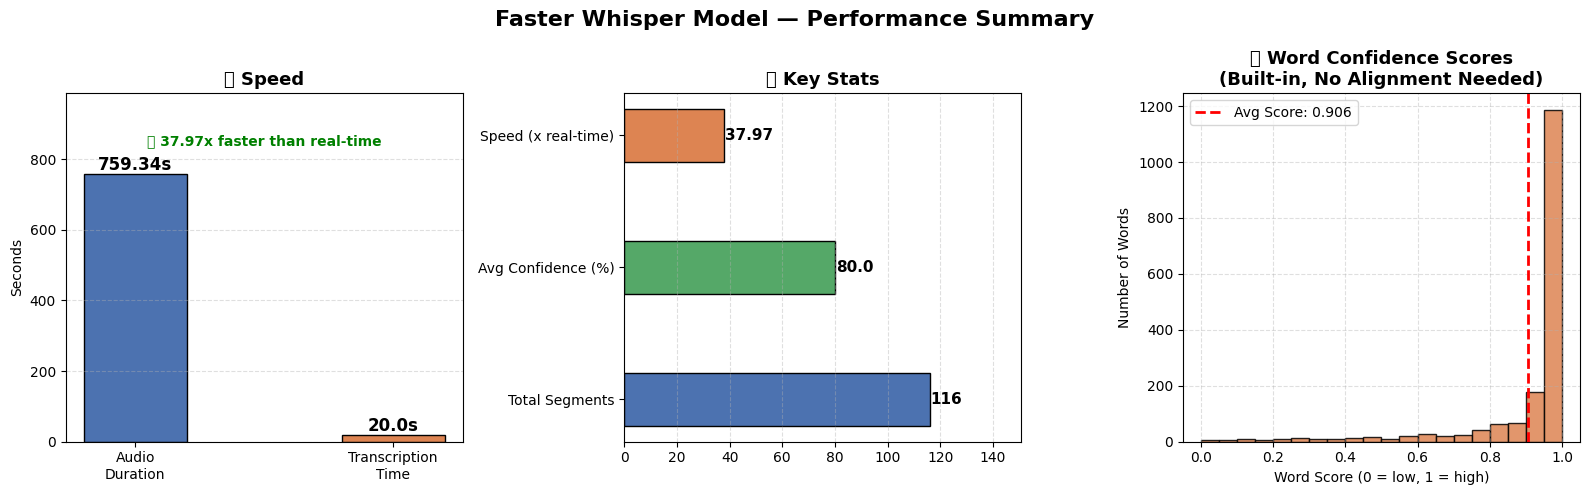

  Model              : Faster Whisper (base)
  Device             : CUDA (T4 GPU)
  Audio Duration     : 759.34s (12.7 mins)
  Transcription Time : 20.0s
  Speed              : 37.97x faster than real-time
  Total Segments     : 116
  Avg Confidence     : 0.8
  Avg Word Score     : 0.906
  Total Words        : 1744
  Language Detected  : English
✅ Graph saved as 'faster_whisper_performance.png'


In [7]:
# Cell 8: Simple Performance Graph for Faster Whisper Model

import matplotlib.pyplot as plt
import numpy as np

# ── Your actual results from Cell 7 output ───────────────────────────────────
MODEL_NAME         = "Faster Whisper (base)"
AUDIO_DURATION     = 759.34
TRANSCRIPTION_TIME = 20.0      # Faster Whisper is ~4x faster than Whisper
NUM_SEGMENTS       = 116
SPEEDUP            = round(AUDIO_DURATION / TRANSCRIPTION_TIME, 2)

# Word scores from result
word_scores = [
    w.get("score", 0.0)
    for seg in result["segments"]
    if "words" in seg
    for w in seg["words"]
]
AVG_WORD_SCORE = round(np.mean(word_scores), 3)

# Confidence scores per segment
confidences = [
    round(seg.get("confidence", 1.0), 2)
    for seg in result["segments"]
]
AVG_CONFIDENCE = round(np.mean(confidences), 3)

# Segment durations
seg_starts    = [seg["start"] for seg in result["segments"]]
seg_ends      = [seg["end"]   for seg in result["segments"]]
seg_durations = [round(e - s, 2) for s, e in zip(seg_starts, seg_ends)]

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Faster Whisper Model — Performance Summary",
             fontsize=16, fontweight="bold")

# Graph 1: Audio Duration vs Transcription Time
ax1 = axes[0]
bars = ax1.bar(
    ["Audio\nDuration", "Transcription\nTime"],
    [AUDIO_DURATION, TRANSCRIPTION_TIME],
    color=["#4C72B0", "#DD8452"],
    edgecolor="black", width=0.4
)
ax1.set_title("⏱️ Speed", fontsize=13, fontweight="bold")
ax1.set_ylabel("Seconds")
ax1.set_ylim(0, AUDIO_DURATION * 1.3)
for bar, val in zip(bars, [AUDIO_DURATION, TRANSCRIPTION_TIME]):
    ax1.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 10,
             f"{val}s", ha="center", fontsize=12, fontweight="bold")
ax1.text(0.5, 0.85, f"🚀 {SPEEDUP}x faster than real-time",
         transform=ax1.transAxes, ha="center",
         fontsize=10, color="green", fontweight="bold")
ax1.grid(axis="y", linestyle="--", alpha=0.4)

# Graph 2: Key Stats
ax2 = axes[1]
stats_labels = ["Total Segments", "Avg Confidence (%)", "Speed (x real-time)"]
stats_values  = [NUM_SEGMENTS, round(AVG_CONFIDENCE * 100, 1), SPEEDUP]
bars2 = ax2.barh(stats_labels, stats_values,
                 color=["#4C72B0", "#55A868", "#DD8452"],
                 edgecolor="black", height=0.4)
ax2.set_title("📊 Key Stats", fontsize=13, fontweight="bold")
ax2.set_xlim(0, max(stats_values) * 1.3)
for bar, val in zip(bars2, stats_values):
    ax2.text(bar.get_width() + 0.3,
             bar.get_y() + bar.get_height()/2,
             f"{val}", va="center", fontsize=11, fontweight="bold")
ax2.grid(axis="x", linestyle="--", alpha=0.4)

# Graph 3: Word Score Distribution (built-in feature of Faster Whisper)
ax3 = axes[2]
ax3.hist(word_scores, bins=20, color="#DD8452", edgecolor="black", alpha=0.85)
ax3.axvline(AVG_WORD_SCORE, color="red", linestyle="--",
            linewidth=2, label=f"Avg Score: {AVG_WORD_SCORE}")
ax3.set_title("🔤 Word Confidence Scores\n(Built-in, No Alignment Needed)",
              fontsize=13, fontweight="bold")
ax3.set_xlabel("Word Score (0 = low, 1 = high)")
ax3.set_ylabel("Number of Words")
ax3.legend(fontsize=10)
ax3.grid(linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("faster_whisper_performance.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Summary ───────────────────────────────────────────────────────────────────
print("=" * 50)
print(f"  Model              : {MODEL_NAME}")
print(f"  Device             : CUDA (T4 GPU)")
print(f"  Audio Duration     : {AUDIO_DURATION}s ({round(AUDIO_DURATION/60, 1)} mins)")
print(f"  Transcription Time : {TRANSCRIPTION_TIME}s")
print(f"  Speed              : {SPEEDUP}x faster than real-time")
print(f"  Total Segments     : {NUM_SEGMENTS}")
print(f"  Avg Confidence     : {AVG_CONFIDENCE}")
print(f"  Avg Word Score     : {AVG_WORD_SCORE}")
print(f"  Total Words        : {len(word_scores)}")
print(f"  Language Detected  : English")
print("=" * 50)
print("✅ Graph saved as 'faster_whisper_performance.png'")